<a href="https://colab.research.google.com/github/m677s345/EECS731_MS_Project_5/blob/main/EECS_MS_Project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install cookiecutter
!cookiecutter https://github.com/drivendata/cookiecutter-data-science
!pip install heatmapz

     |████████████████████████████████| 51kB 1.7MB/s 


project_name [project_name]: repo_name [project_name]: 
author_name [Your name (or your organization/company/team)]: 
description [A short description of the project.]: 
Select open_source_license:
1 - MIT
2 - BSD-3-Clause
3 - No license file
Choose from 1, 2, 3 [1]: 
s3_bucket [[OPTIONAL] your-bucket-for-syncing-data (do not include 's3://')]: 
aws_profile [default]: 
Select python_interpreter:
1 - python3
2 - python
Choose from 1, 2 [1]: 







# Packages and Data cleanup 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm, skew 
from scipy import stats 
import statsmodels.api as sm 


df_prod = pd.read_csv('/content/project_name/data/raw/Historical Product Demand.csv',header=0)

In [5]:
df_prod.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,7/27/2012,100
1,Product_0979,Whse_J,Category_028,1/19/2012,500
2,Product_0979,Whse_J,Category_028,2/3/2012,500
3,Product_0979,Whse_J,Category_028,2/9/2012,500
4,Product_0979,Whse_J,Category_028,3/2/2012,500


Right away we can see that there is a large amount of data in this dataset. We can see that there is date time data not in date time form and the product codes have Product_ before the ID number. We can also see that there is wharehouse information and product categories. For this project we will focus on the codes and the datetime however we may be able to get some information from the other coulmns. 

In [6]:
df_prod.shape

(1048575, 5)

In [7]:
df_prod.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand         int64
dtype: object

In [8]:
# Check any number of columns with NaN
print(df_prod.isnull().any().sum(), ' / ', len(df_prod.columns))
# Check any number of data points with NaN
print(df_prod.isnull().any(axis=1).sum(), ' / ', len(df_prod))

1  /  5
11239  /  1048575


We can see that there is a small amount of data relitave to the total data we are going to assume that this is not going to impact the product we choose too much and drop that data from the dataset. 

In [9]:
print (df_prod.isna().sum())
df_prod.dropna(axis=0, inplace=True) #remove all rows with na's.
df_prod.reset_index(drop=True)

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,7/27/2012,100
1,Product_0979,Whse_J,Category_028,1/19/2012,500
2,Product_0979,Whse_J,Category_028,2/3/2012,500
3,Product_0979,Whse_J,Category_028,2/9/2012,500
4,Product_0979,Whse_J,Category_028,3/2/2012,500
...,...,...,...,...,...
1037331,Product_1791,Whse_J,Category_006,4/27/2016,1000
1037332,Product_1974,Whse_J,Category_006,4/27/2016,1
1037333,Product_1787,Whse_J,Category_006,4/28/2016,2500
1037334,Product_0901,Whse_J,Category_023,10/7/2016,50


Let's group the data by a few different metrics to see how the data is broken down and get a better understanding of our dataset. We can see that there is far more products shipping from Wharehouse J than the other warehouses. As far as total number of shippments it is still the leader but warehouse A is in the same order of magnitude of orders. Finally, Category 19 has the highest number of products in it. This may help us determine the bigger picture of which products should be forcasted with time series. 

In [10]:
print(df_prod.groupby('Warehouse')['Product_Code'].nunique())
print('------------------------------------------')
print(df_prod['Warehouse'].value_counts().sort_values(ascending = False))
print('------------------------------------------')
print(df_prod.groupby('Product_Category')['Product_Code'].nunique())

Warehouse
Whse_A     427
Whse_C     244
Whse_J    1625
Whse_S     553
Name: Product_Code, dtype: int64
------------------------------------------
Whse_J    764447
Whse_A    142335
Whse_S     88200
Whse_C     42354
Name: Warehouse, dtype: int64
------------------------------------------
Product_Category
Category_001    278
Category_002      1
Category_003     12
Category_004      1
Category_005    185
Category_006    112
Category_007    141
Category_008      7
Category_009    102
Category_010      7
Category_011     59
Category_012     24
Category_013     13
Category_014      1
Category_015     64
Category_016      4
Category_017      8
Category_018     16
Category_019    534
Category_020     23
Category_021    143
Category_022     46
Category_023     62
Category_024     53
Category_025      2
Category_026     41
Category_027      2
Category_028     57
Category_029      4
Category_030     99
Category_031      6
Category_032     49
Category_033      4
Name: Product_Code, dtype: int64


We next need to convert the date column to a actual date data type in our dataframe as well as getting the min and max dates. 

In [11]:
df_prod['Date'] = pd.to_datetime(df_prod['Date'])

In [12]:
df_prod.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
dtype: object

In [13]:
df_prod.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


The below code gives us the domain for the purchases that we have data for. We also need to encode the product number or we could just remove the Product_ since every datapoint has that feature.

In [14]:
df_prod['Date'].min(), df_prod['Date'].max()

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [18]:
df_prod['Product_Code'] = df_prod['Product_Code'].astype(str)
df_prod['Product_Code'] = df_prod['Product_Code'].replace('[Product_]', '', regex=True).astype(int)

In [19]:
#Index the date
df_prod = df_prod.set_index('Date')
df_prod.index #Lets check the index

DatetimeIndex(['2012-07-27', '2012-01-19', '2012-02-03', '2012-02-09',
               '2012-03-02', '2012-04-19', '2012-06-05', '2012-06-27',
               '2012-07-23', '2012-08-29',
               ...
               '2016-11-11', '2016-11-02', '2016-07-07', '2016-08-17',
               '2016-11-10', '2016-04-27', '2016-04-27', '2016-04-28',
               '2016-10-07', '2016-06-27'],
              dtype='datetime64[ns]', name='Date', length=1037336, freq=None)

In [20]:
df_prod.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,993,Whse_J,Category_028,100
2012-01-19,979,Whse_J,Category_028,500
2012-02-03,979,Whse_J,Category_028,500
2012-02-09,979,Whse_J,Category_028,500
2012-03-02,979,Whse_J,Category_028,500


# Product selection and Time Series Forcasting for product 1

First I chose product code 349 because it had the highest Order demand with the assumption that that would relate to the number of transactions. First impressions of this data is a liner fit would predict it well. There is a near monotonic increase in the Order demand. A bit of feature engineering we have done here iscreate a series that contains the scecific product code and the cumlitave sum from every 2 weeks of purchases.

In [21]:

series_stat = df_prod.loc[df_prod['Product_Code'] == 349]['Order_Demand']
series = series_stat.resample('14D').sum()
series = series.cumsum()

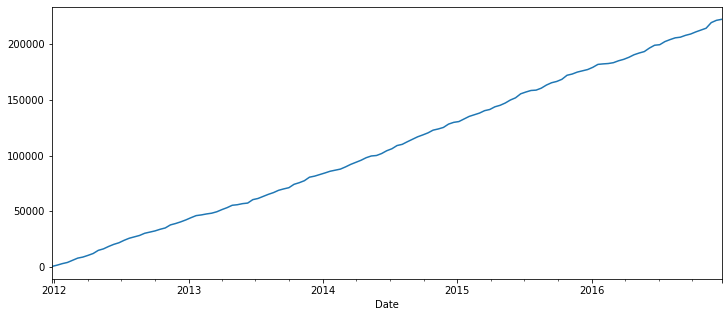

In [25]:
series.plot(figsize=(12,5))
plt.show()

We can start breaking down the individual statistics. Above we creates a series with a specific series containing all the data for the purpose of seeing the statistics for the specific product. An interesting thing we see here is that the dataset is shifted left. There is a large amount of small purchases compaired to larger ones but overall the skew score shows that the dataset is higly skewed. A simple method may have a hard time prediciting this based on a normal distribution. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


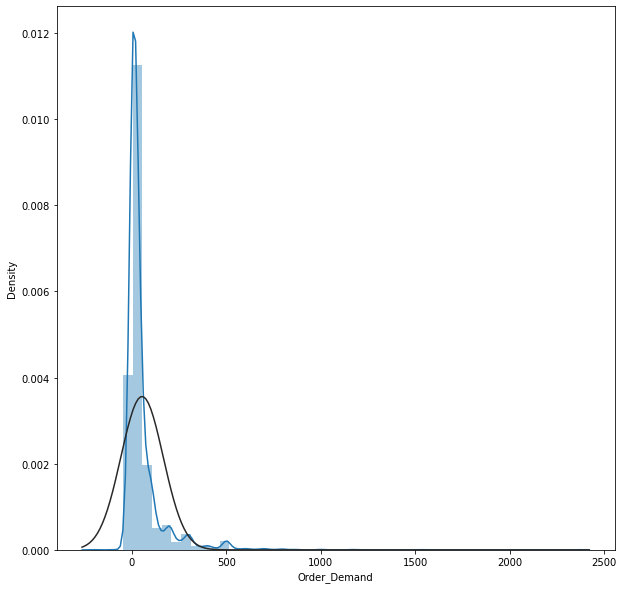

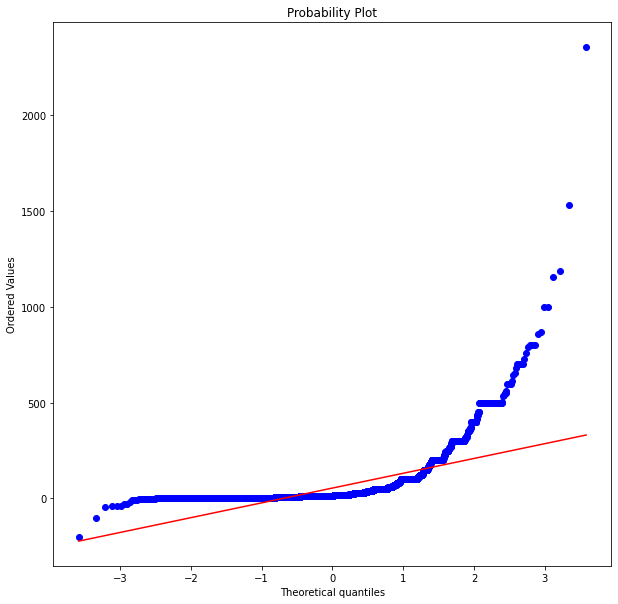

In [31]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,10

sb.distplot(series_stat, fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(series_stat, plot=plt)
plt.show()

In [32]:
series_stat.skew()

5.9057879373668465

In [33]:
print(series['2014'])

Date
2014-01-06     84362
2014-01-20     85891
2014-02-03     86899
2014-02-17     87820
2014-03-03     89797
2014-03-17     92048
2014-03-31     93876
2014-04-14     95730
2014-04-28     98022
2014-05-12     99587
2014-05-26    100010
2014-06-09    101762
2014-06-23    104293
2014-07-07    106057
2014-07-21    108939
2014-08-04    110003
2014-08-18    112354
2014-09-01    114522
2014-09-15    116777
2014-09-29    118467
2014-10-13    120291
2014-10-27    122746
2014-11-10    123796
2014-11-24    125167
2014-12-08    128169
2014-12-22    129727
Freq: 14D, Name: Order_Demand, dtype: int64


We can actually see fairly good seasonality by decomposing the dataset 

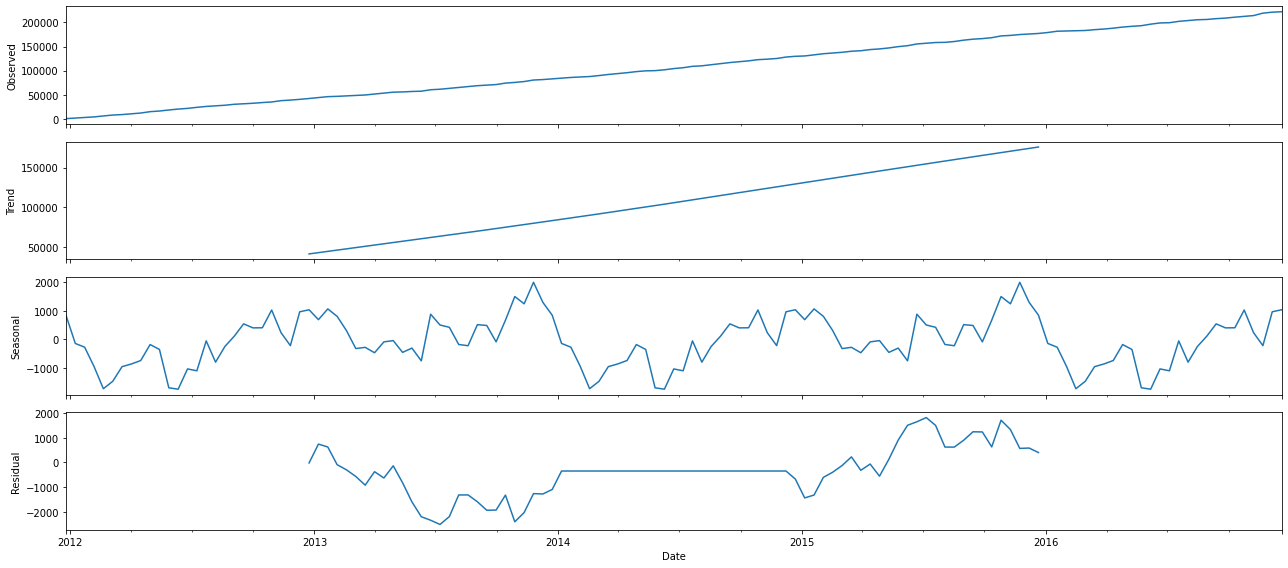

In [34]:
#The best part about time series data and decomposition is that you can break down the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(series, model='additive')
fig = decomposition.plot()
plt.show()

In [39]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 26) for x in list(itertools.product(p, d, q))]

Here we ar looking to get the best paramaters for Seasonal AIRMA by trying different combinations of paramaters and choosing the one with the lowest AIC. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. It is also able to measure how well a model fits the data while taking into account the overall complexity of the model. 

In [40]:

#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(series,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}26 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 26)26 - AIC:3425.1840286183865
SARIMA(0, 0, 0)x(0, 0, 1, 26)26 - AIC:2728.6598155591064
SARIMA(0, 0, 0)x(0, 1, 0, 26)26 - AIC:2525.455144596444
SARIMA(0, 0, 0)x(0, 1, 1, 26)26 - AIC:1899.4411424360846
SARIMA(0, 0, 0)x(1, 0, 0, 26)26 - AIC:2396.4294480831895
SARIMA(0, 0, 0)x(1, 0, 1, 26)26 - AIC:2315.703875759951
SARIMA(0, 0, 0)x(1, 1, 0, 26)26 - AIC:1572.3867698392864


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(0, 0, 0)x(1, 1, 1, 26)26 - AIC:1556.9809974286736
SARIMA(0, 0, 1)x(0, 0, 0, 26)26 - AIC:3306.8318580031832
SARIMA(0, 0, 1)x(0, 0, 1, 26)26 - AIC:2626.814018906815
SARIMA(0, 0, 1)x(0, 1, 0, 26)26 - AIC:2424.0038008614915


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(0, 0, 1)x(0, 1, 1, 26)26 - AIC:1775.1155556944998
SARIMA(0, 0, 1)x(1, 0, 0, 26)26 - AIC:2668.9976934340048
SARIMA(0, 0, 1)x(1, 0, 1, 26)26 - AIC:2619.868839301527
SARIMA(0, 0, 1)x(1, 1, 0, 26)26 - AIC:1842.2228083585044
SARIMA(0, 0, 1)x(1, 1, 1, 26)26 - AIC:2563.5125253829574
SARIMA(0, 1, 0)x(0, 0, 0, 26)26 - AIC:2311.0515334386528
SARIMA(0, 1, 0)x(0, 0, 1, 26)26 - AIC:1783.7072993959302
SARIMA(0, 1, 0)x(0, 1, 0, 26)26 - AIC:1716.8519691119025


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(0, 1, 0)x(0, 1, 1, 26)26 - AIC:2145.733026343796
SARIMA(0, 1, 0)x(1, 0, 0, 26)26 - AIC:1731.2176887564367
SARIMA(0, 1, 0)x(1, 0, 1, 26)26 - AIC:1693.278548582422
SARIMA(0, 1, 0)x(1, 1, 0, 26)26 - AIC:1287.211181633536


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(0, 1, 0)x(1, 1, 1, 26)26 - AIC:2947.351108454655
SARIMA(0, 1, 1)x(0, 0, 0, 26)26 - AIC:2221.521919381963
SARIMA(0, 1, 1)x(0, 0, 1, 26)26 - AIC:1740.0444271479173
SARIMA(0, 1, 1)x(0, 1, 0, 26)26 - AIC:1702.9367287867524


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(0, 1, 1)x(0, 1, 1, 26)26 - AIC:2772.132107544152
SARIMA(0, 1, 1)x(1, 0, 0, 26)26 - AIC:1732.3294750505393
SARIMA(0, 1, 1)x(1, 0, 1, 26)26 - AIC:1678.9935613515665
SARIMA(0, 1, 1)x(1, 1, 0, 26)26 - AIC:1288.316467409795


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(0, 1, 1)x(1, 1, 1, 26)26 - AIC:2385.302681988991
SARIMA(1, 0, 0)x(0, 0, 0, 26)26 - AIC:2192.1983744185645
SARIMA(1, 0, 0)x(0, 0, 1, 26)26 - AIC:1725.2729856701717


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 0, 0)x(0, 1, 0, 26)26 - AIC:1735.1745614057083
SARIMA(1, 0, 0)x(0, 1, 1, 26)26 - AIC:1286.1054333135833
SARIMA(1, 0, 0)x(1, 0, 0, 26)26 - AIC:1718.6864872798926
SARIMA(1, 0, 0)x(1, 0, 1, 26)26 - AIC:1718.1506556721945
SARIMA(1, 0, 0)x(1, 1, 0, 26)26 - AIC:1290.0168232617946
SARIMA(1, 0, 0)x(1, 1, 1, 26)26 - AIC:1287.6162921229795
SARIMA(1, 0, 1)x(0, 0, 0, 26)26 - AIC:2152.409996462742
SARIMA(1, 0, 1)x(0, 0, 1, 26)26 - AIC:1704.327288124507
SARIMA(1, 0, 1)x(0, 1, 0, 26)26 - AIC:1720.823444098918
SARIMA(1, 0, 1)x(0, 1, 1, 26)26 - AIC:1360.0123660263969


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 0, 1)x(1, 0, 0, 26)26 - AIC:1716.1360479528628
SARIMA(1, 0, 1)x(1, 0, 1, 26)26 - AIC:1699.277478962026
SARIMA(1, 0, 1)x(1, 1, 0, 26)26 - AIC:1291.733126632401
SARIMA(1, 0, 1)x(1, 1, 1, 26)26 - AIC:1274.3880365250457
SARIMA(1, 1, 0)x(0, 0, 0, 26)26 - AIC:2158.3835495034446
SARIMA(1, 1, 0)x(0, 0, 1, 26)26 - AIC:1733.7675002308179
SARIMA(1, 1, 0)x(0, 1, 0, 26)26 - AIC:1718.8343662989566


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 1, 0)x(0, 1, 1, 26)26 - AIC:2819.960011590444
SARIMA(1, 1, 0)x(1, 0, 0, 26)26 - AIC:1716.173052434123
SARIMA(1, 1, 0)x(1, 0, 1, 26)26 - AIC:1695.1118733052256
SARIMA(1, 1, 0)x(1, 1, 0, 26)26 - AIC:1273.2637645244658


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 1, 0)x(1, 1, 1, 26)26 - AIC:2535.7049824301675
SARIMA(1, 1, 1)x(0, 0, 0, 26)26 - AIC:2073.562148885069
SARIMA(1, 1, 1)x(0, 0, 1, 26)26 - AIC:1665.694485135052
SARIMA(1, 1, 1)x(0, 1, 0, 26)26 - AIC:1699.2031123957347


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 1, 1)x(0, 1, 1, 26)26 - AIC:2805.508685014231
SARIMA(1, 1, 1)x(1, 0, 0, 26)26 - AIC:1681.3738697203732
SARIMA(1, 1, 1)x(1, 0, 1, 26)26 - AIC:1674.5611489022863
SARIMA(1, 1, 1)x(1, 1, 0, 26)26 - AIC:1270.583074067209


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 1, 1)x(1, 1, 1, 26)26 - AIC:2631.636447334202


In [81]:
#Fit the model with the best params.
#SARIMA(1, 1, 1)x(1, 1, 0, 26)26 - AIC:1270.583074067209

#we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(series,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 26),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5924      0.280     -2.113      0.035      -1.142      -0.043
ma.L1          0.8053      0.211      3.823      0.000       0.392       1.218
ar.S.L26      -0.5159      0.122     -4.229      0.000      -0.755      -0.277
sigma2      7.734e+05   1.27e+05      6.067      0.000    5.24e+05    1.02e+06


Here is a plot of several diagnostic quantities. we can see that there is good agreement with the normal distribution. The qq plot in the lower left also shows good agreement with the normal distribution. 

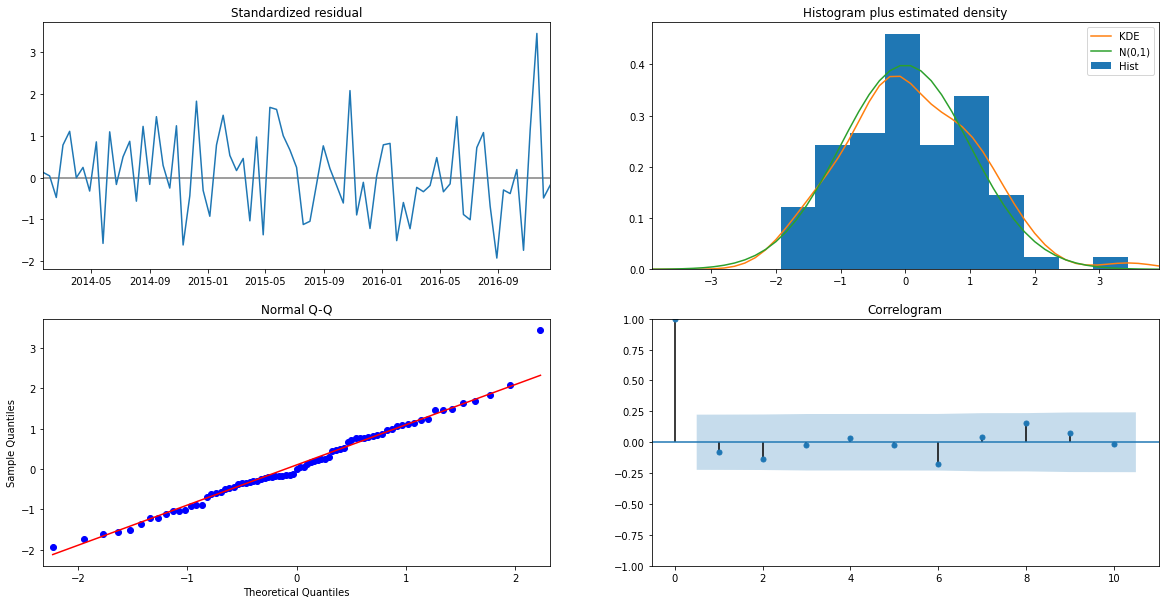

In [82]:
#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(20,10))
plt.show()


Here we have plotted what the prediction looks like when compaired to the origional data. It begns predicting actually as of the first of Jan in the secon plot below. We can see that the data fits really well. 

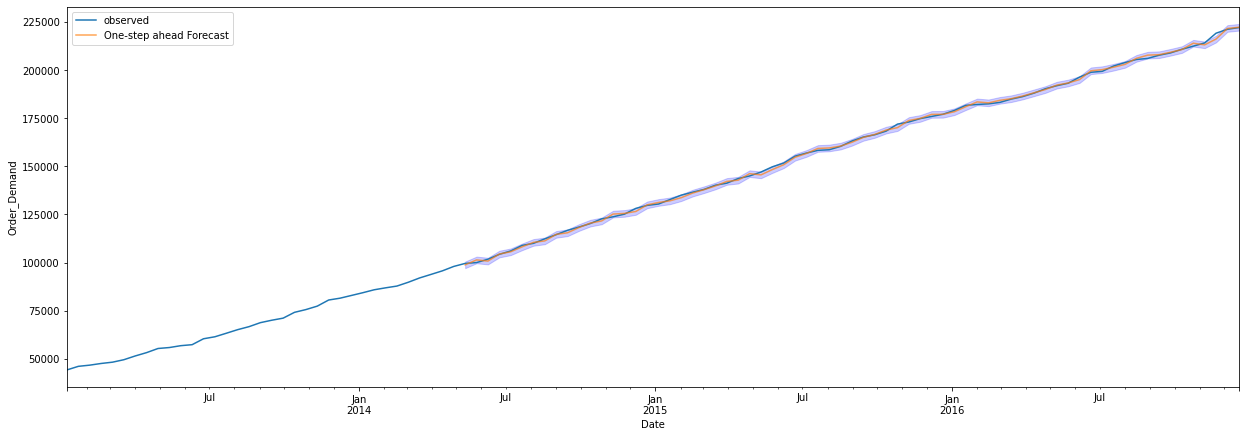

In [43]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2014-05-12'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = series['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(21, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows the confidence level in the forecasts. 

In [44]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = series['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 966156.53


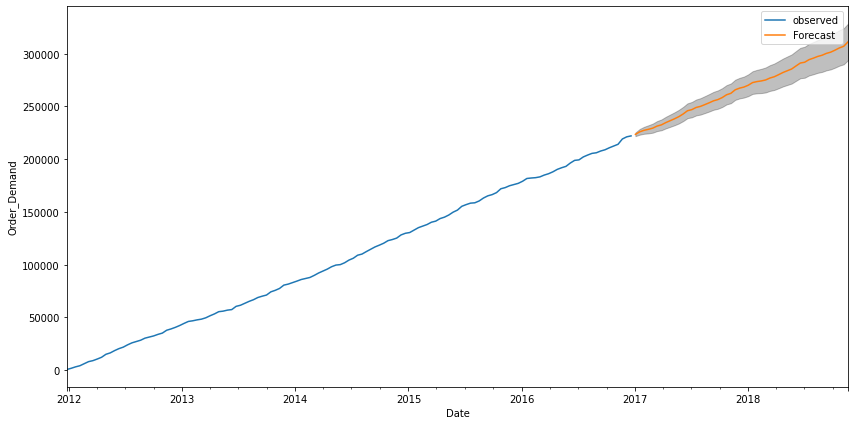

In [45]:
#The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = series.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#Far out values are naturally more prone to variance. The grey area is the confidence we have in the predictions.

Overall in a sample that has a motonic increase like this one we should be able to accuratly predict the future prices with ease. It is more interesting to predict time series data that is subject to more change 

# Product selection and Time Series Forcasting for product 2

I chose 690 because unlike the previous product there is some varience in the useage of the product and think that it is a more interesting problem for predicting. 

In [53]:

series2_stat = df_prod.loc[df_prod['Product_Code'] == 690]['Order_Demand']
series2 = series2_stat.resample('14D').sum()
series2 = series2.cumsum()

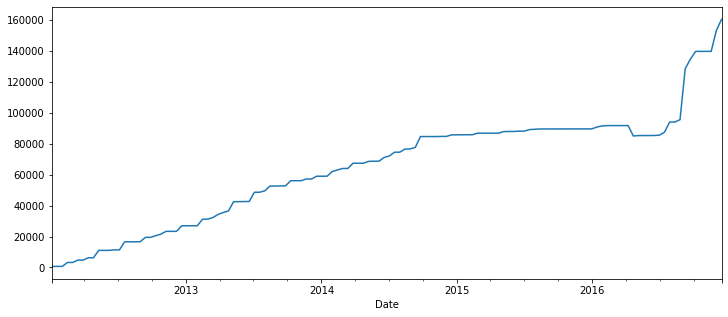

In [54]:
series2.plot(figsize=(12,5))
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


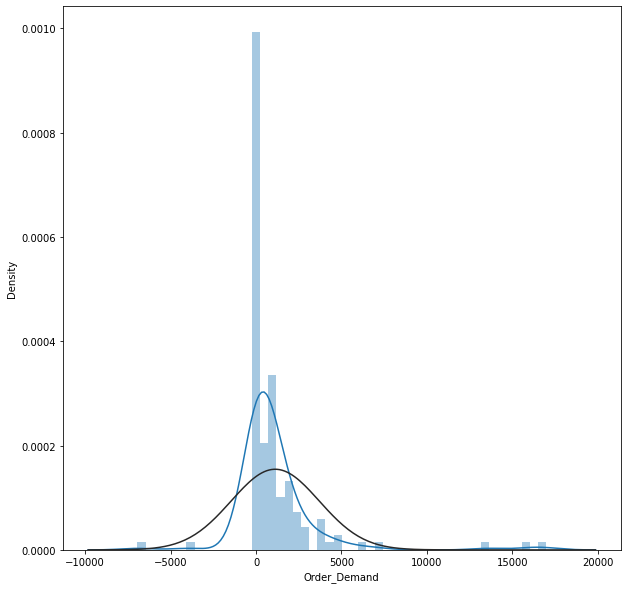

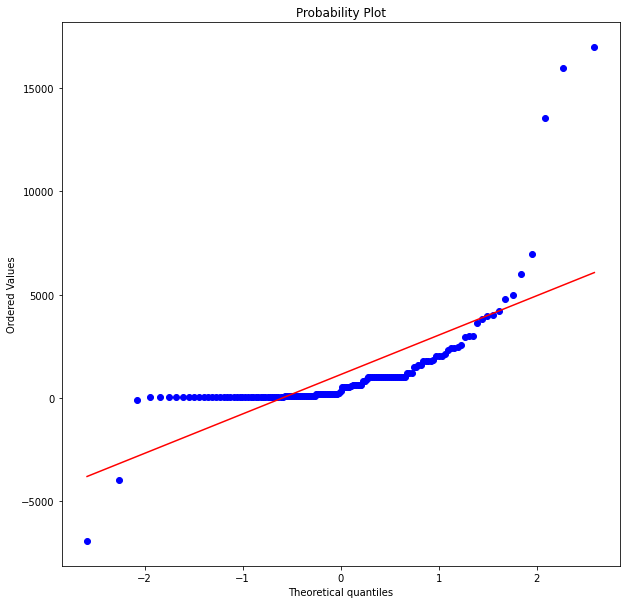

In [60]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,10

sb.distplot(series2_stat, fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(series2_stat, plot=plt)
plt.show()

In [56]:
series2_stat.skew()

5.9057879373668465

In [58]:
print(series2['2014'])

Date
2014-01-02    59040
2014-01-16    59040
2014-01-30    62050
2014-02-13    63050
2014-02-27    64050
2014-03-13    64050
2014-03-27    67450
2014-04-10    67450
2014-04-24    67450
2014-05-08    68650
2014-05-22    68750
2014-06-05    68770
2014-06-19    71170
2014-07-03    72180
2014-07-17    74570
2014-07-31    74590
2014-08-14    76590
2014-08-28    76680
2014-09-11    77690
2014-09-25    84700
2014-10-09    84700
2014-10-23    84700
2014-11-06    84700
2014-11-20    84800
2014-12-04    84800
2014-12-18    85800
Freq: 14D, Name: Order_Demand, dtype: int64


For this product we also see some really good seasonality in the decomposition.

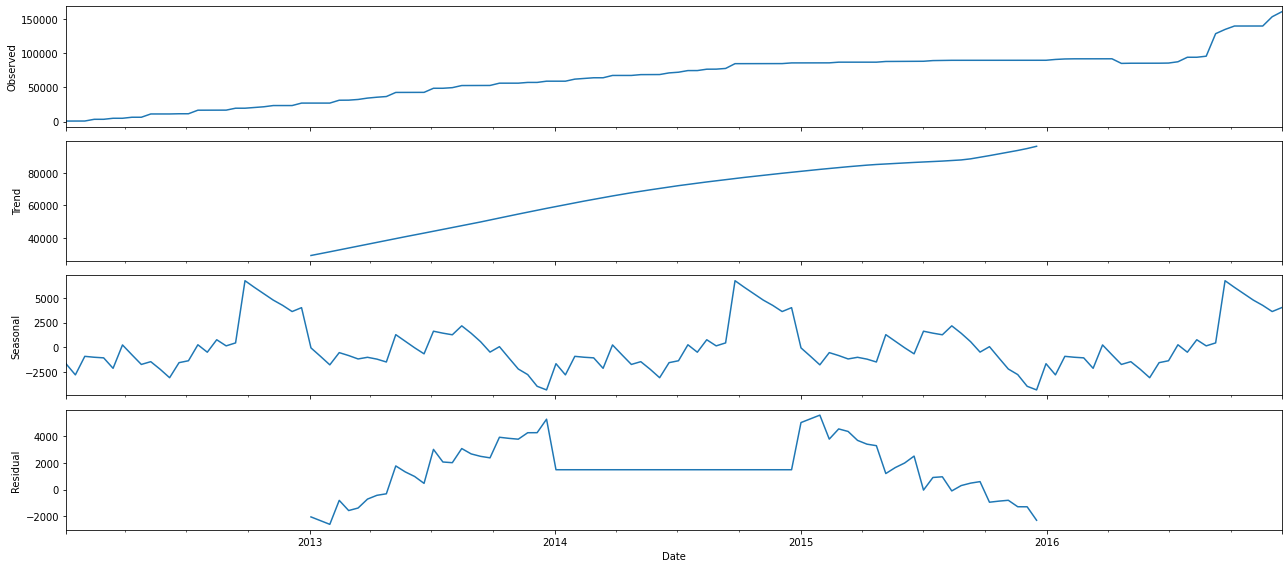

In [61]:
#The best part about time series data and decomposition is that you can break down the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(series2, model='additive')
fig = decomposition.plot()
plt.show()

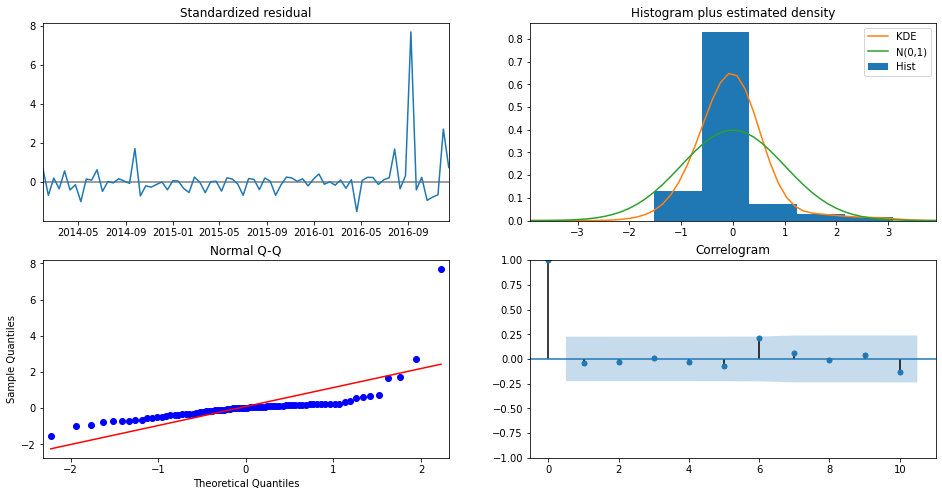

In [68]:
#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#What to look for?
#1. Residuals SHOULD be Normally Distributed ; Check
#Top Right: The (orange colored) KDE line should be closely matched with green colored N(0,1) line. This is the standard notation
#for normal distribution with mean 0 and sd 1.
#Bottom Left: The qq plot shows the ordered distribution of residuals (blue dots) follows the linear trend of the samples 
#taken from a standard normal distribution with N(0, 1). 

#2. #Residuals are not correlated; Check
#Top Left: The standard residuals don’t display any obvious seasonality and appear to be white noise. 
#Bottom Right: The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have 
#low correlation with its own lagged versions.

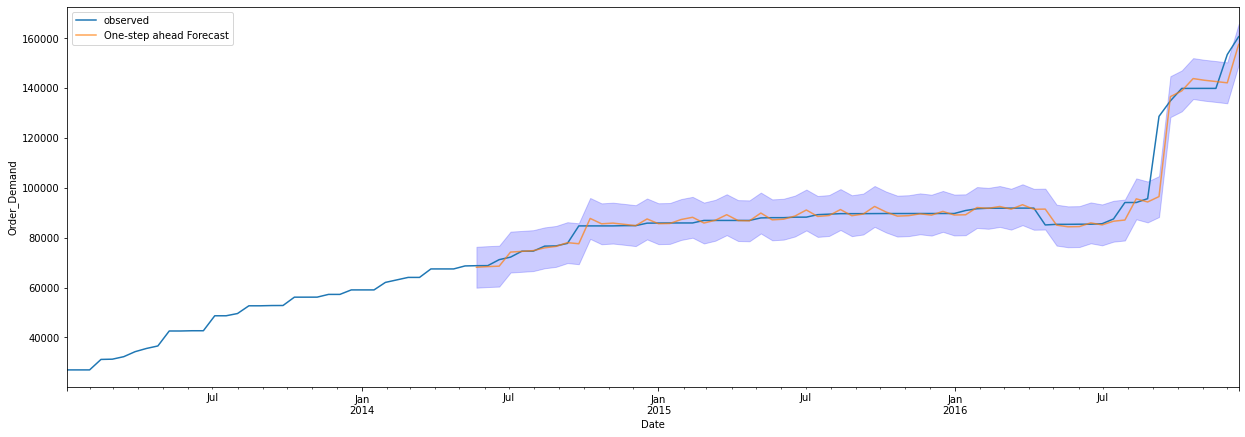

In [70]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2014-05-22'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = series2['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(21, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows the confidence level in the forecasts. 

In [72]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = series2['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 52530690.44


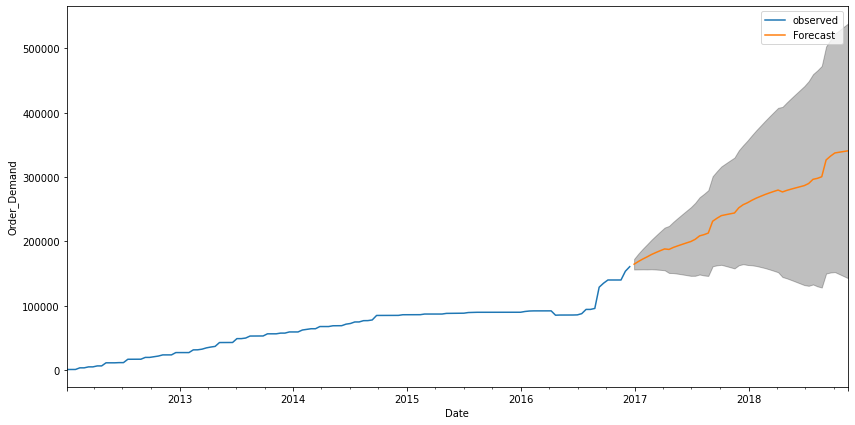

In [74]:
#The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = series2.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#Far out values are naturally more prone to variance. The grey area is the confidence we have in the predictions.

This is a better representation of how the time series data can beunpredictable. unilike the previous example, in the last part of the dataset there are some major changes to the behavior of the data increasing the error and uncertanty. The fitted data does fit the data within reason; however there is a higher uncertanty for the forcasted data. 